# 📉 Trend Decay Analysis (Multi-signal Combined)

**Goal**  
Based on `video_hourly_activity.parquet`, compute trend decay features for each video:  
- Half-life (how fast activity halves)  
- Decay strength (0–1, stronger = sharper decline)  
- State (rising / peaking / decaying / stale)  

**Input**: `video_hourly_activity.parquet`  
**Output**: `signal_decay.csv` (one combined result per video, across all signals)

In [1]:
# === Config ===
INPUT_PARQUET = "/kaggle/input/aggregate-to-video-hourly-activity/video_hourly_activity.parquet"
OUTPUT_CSV    = "/kaggle/working/signal_decay.csv"

# ✅ Only use the two robust signals
SIGNAL_COLS = ["comment_count", "unique_commenters"]

EMA_SPAN_HOURS        = 3
MIN_POINTS_POST_PEAK  = 4
EPS                   = 1e-6
DECAY_NORM            = 0.20

# Guards (balanced)
MIN_PEAK_VALUE        = 1.0
MIN_POST_NONZERO      = 3
MIN_EMA_FRAC_FOR_FIT  = 0.005
MIN_DECAY_SLOPE       = -0.005
MAX_WINDOW_HRS        = 24 * 14

# === Imports ===
import math
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas.io.formats.format")

In [2]:
df = pd.read_parquet(INPUT_PARQUET)

# Standardize timestamp column
df["ts"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.dropna(subset=["ts"])
df = df.sort_values(["videoId", "ts"]).reset_index(drop=True)

print(df.head())
print(f"Rows: {len(df):,} | Videos: {df['videoId'].nunique():,}")

             datetime  videoId  comment_count  unique_commenters  \
0 2020-02-12 05:00:00        0              1                  1   
1 2020-02-12 09:00:00        0              4                  2   
2 2020-02-12 10:00:00        0             21                  5   
3 2020-02-12 11:00:00        0              4                  1   
4 2020-02-12 12:00:00        0              7                  3   

   avg_emoji_per_comment  hashtag_density                  ts  
0               0.000000         0.000000 2020-02-12 05:00:00  
1               0.250000         0.000000 2020-02-12 09:00:00  
2               0.095238         0.000000 2020-02-12 10:00:00  
3               0.000000         0.000000 2020-02-12 11:00:00  
4               0.142857         0.142857 2020-02-12 12:00:00  
Rows: 2,143,123 | Videos: 39,938


In [3]:
def reindex_hourly(g, value_col):
    """Make a continuous hourly index and fill gaps with 0 for the signal."""
    g = g.set_index("ts").sort_index()
    full_idx = pd.date_range(g.index.min().floor("h"), g.index.max().ceil("h"), freq="h")
    g = g.reindex(full_idx)
    g["videoId"] = g["videoId"].ffill().bfill()
    g[value_col] = g[value_col].fillna(0.0).astype(float)
    g.index.name = "ts"
    return g.reset_index()

def ema(series, span):
    return series.ewm(span=span, adjust=False, min_periods=1).mean()

def fit_exp_decay(post_df, value_col, peak_ts, eps=EPS):
    """Fit ln(y) ~ a + b*t on post-peak points; return slope b, R², and half-life (hours)."""
    if post_df.empty:
        return np.nan, np.nan, np.nan
    t_hours = (post_df["ts"] - peak_ts).dt.total_seconds().values.reshape(-1, 1) / 3600.0
    y = post_df[value_col].values.astype(float) + eps
    y_log = np.log(y)
    reg = LinearRegression().fit(t_hours, y_log)
    slope = float(reg.coef_[0])
    r2 = float(reg.score(t_hours, y_log))
    half_life = (math.log(2) / -slope) if slope < 0 else math.inf
    return slope, r2, half_life

def recent_linear_slope(ts, y, last_k=6):
    """Linear slope over the last K points (units: value per hour)."""
    if len(y) < 2:
        return 0.0
    x = (ts - ts.min()).dt.total_seconds().values / 3600.0
    x_last = x[-last_k:] if len(x) >= last_k else x
    y_last = y[-last_k:] if len(y) >= last_k else y
    X = x_last.reshape(-1, 1)
    return float(LinearRegression().fit(X, y_last).coef_[0])

def classify_state(s_ema, peak_val, peak_ts):
    """Heuristic state label using recent slope and level vs peak."""
    if len(s_ema) == 0:
        return "stale", np.nan
    ts = s_ema.index.to_series()
    vals = s_ema.values
    rec_slope = recent_linear_slope(ts, vals, last_k=6)
    recent_mean = float(pd.Series(vals[-6:] if len(vals) >= 6 else vals).mean())
    ratio = recent_mean / max(peak_val, EPS)
    hours_since_peak = (ts.iloc[-1] - peak_ts).total_seconds() / 3600.0
    if hours_since_peak <= 3 and abs(rec_slope) < 1e-6:
        state = "peaking"
    elif rec_slope > 0 and ratio < 0.9:
        state = "rising"
    elif (rec_slope <= 0 and ratio <= 0.6) or (ratio <= 0.1 and hours_since_peak > 24):
        state = "decaying" if ratio > 0.05 else "stale"
    else:
        state = "decaying" if rec_slope <= 0 else "rising"
    return state, ratio

def strength_score(slope_log, r2, norm=DECAY_NORM):
    """
    Combine steepness and fit quality into a stable [0,1] decay strength.
    - steeper negative slope and higher R² => larger score.
    - always clipped to [0,1] to avoid tiny/huge extremes.
    """
    if not np.isfinite(slope_log) or not np.isfinite(r2):
        return 0.0
    raw = (-slope_log) * max(0.0, r2)
    score = raw / norm
    return float(np.clip(score, 0.0, 1.0))

In [4]:
def process_one_video(g, value_col):
    # 1) reindex hourly + EMA
    g2 = reindex_hourly(g[["videoId","ts",value_col]].copy(), value_col)
    g2["ema"] = ema(g2[value_col], EMA_SPAN_HOURS)

    # 2) find peak
    peak_idx = g2["ema"].idxmax()
    peak_ts  = g2.loc[peak_idx, "ts"]
    peak_val = float(g2.loc[peak_idx, "ema"])

    # Guard: meaningful peak?
    if peak_val < MIN_PEAK_VALUE:
        s_ema = g2.set_index("ts")["ema"]
        state, ratio = classify_state(s_ema, peak_val, peak_ts)
        return dict(
            videoId=g2["videoId"].iloc[0], signal=value_col,
            peak_ts=peak_ts, peak_value=peak_val,
            half_life_hours=np.nan, slope_log=np.nan, decay_r2=np.nan, decay_strength=0.0,
            t_since_peak_hours=float((g2["ts"].iloc[-1] - peak_ts).total_seconds()/3600.0),
            recent_mean_ratio=float(ratio), state="no_decay"
        )

    # 3) post-peak window (clip horizon, drop tiny points)
    post = g2[g2["ts"] > peak_ts][["ts","ema"]].copy()
    if post.empty:
        s_ema = g2.set_index("ts")["ema"]
        state, ratio = classify_state(s_ema, peak_val, peak_ts)
        return dict(
            videoId=g2["videoId"].iloc[0], signal=value_col,
            peak_ts=peak_ts, peak_value=peak_val,
            half_life_hours=np.nan, slope_log=np.nan, decay_r2=np.nan, decay_strength=0.0,
            t_since_peak_hours=float((g2["ts"].iloc[-1] - peak_ts).total_seconds()/3600.0),
            recent_mean_ratio=float(ratio), state="no_decay"
        )

    post = post[post["ts"] <= peak_ts + pd.Timedelta(hours=MAX_WINDOW_HRS)]
    thr  = max(peak_val * MIN_EMA_FRAC_FOR_FIT, EPS)
    post = post[post["ema"] >= thr]

    # 4) fit or skip
    if post["ema"].gt(0).sum() < MIN_POST_NONZERO:
        slope, r2, half_life = np.nan, np.nan, np.nan
    else:
        slope, r2, half_life = fit_exp_decay(post, "ema", peak_ts)
        # treat non-negative / too-flat slopes as no-decay
        if (not np.isfinite(slope)) or slope > MIN_DECAY_SLOPE:
            slope, r2, half_life = np.nan, np.nan, np.nan

    # 5) strength / state
    decay_strength = strength_score(slope, r2)
    s_ema = g2.set_index("ts")["ema"]
    state, ratio = classify_state(s_ema, peak_val, peak_ts)

    # 6) cap/sanitize half-life
    if np.isfinite(half_life) and half_life > MAX_WINDOW_HRS:
        half_life = np.nan
    elif not np.isfinite(half_life):
        half_life = np.nan

    # IMPORTANT: only force "no_decay" if we truly couldn't fit a decay (NaN half-life),
    # but DON'T force it just because strength clipped to 0
    if np.isnan(half_life):
        state = "no_decay"

    return dict(
        videoId=g2["videoId"].iloc[0], signal=value_col,
        peak_ts=peak_ts, peak_value=peak_val,
        half_life_hours=half_life, slope_log=slope, decay_r2=r2,
        decay_strength=decay_strength,
        t_since_peak_hours=float((g2["ts"].iloc[-1] - peak_ts).total_seconds()/3600.0),
        recent_mean_ratio=float(ratio), state=state
    )

In [5]:
# === Run per-signal for every video ===
all_results = []
for sig in SIGNAL_COLS:
    for vid, g in tqdm(df.groupby("videoId"), desc=f"Processing {sig}"):
        try:
            res = process_one_video(g, sig)
            all_results.append(res)
        except Exception as e:
            all_results.append({
                "videoId": vid, "signal": sig, "peak_ts": pd.NaT, "peak_value": np.nan,
                "half_life_hours": np.nan, "slope_log": np.nan, "decay_r2": np.nan,
                "decay_strength": 0.0, "t_since_peak_hours": np.nan,
                "recent_mean_ratio": np.nan, "state": "no_decay"
            })
            print(f"[WARN] {vid} {sig}: {e}")

multi_df = pd.DataFrame(all_results).replace([np.inf, -np.inf], np.nan)

# clip strengths to [0,1]
multi_df["decay_strength"] = multi_df["decay_strength"].astype(float).clip(0.0, 1.0)

# only keep half-life from signals that actually show some decay
usable_hl = multi_df.copy()
usable_hl.loc[usable_hl["decay_strength"] <= 0.05, "half_life_hours"] = np.nan

# Combine across the two signals:
# - strength: MAX (if either signal decays, we capture it)
# - half-life: MEDIAN of usable half-lives (robust to one bad fit)
combined_df = pd.DataFrame({
    "decay_strength_combined": multi_df.groupby("videoId")["decay_strength"].max(),
    "half_life_hours_combined": usable_hl.groupby("videoId")["half_life_hours"].median()
})

# State: majority vote; if both are 'no_decay', keep 'no_decay'
state_mode = multi_df.groupby("videoId")["state"].agg(lambda x: x.mode()[0] if len(x.mode()) else "no_decay")
combined_df["state_combined"] = state_mode

# Export-friendly half-life
def _hl_export(x):
    return "no_decay" if (not np.isfinite(x)) else float(x)

combined_df["half_life_hours_combined"] = combined_df["half_life_hours_combined"].apply(_hl_export)

# Save & preview
combined_df.to_csv(OUTPUT_CSV, index=True)
print(f"Saved: {OUTPUT_CSV} | Rows: {len(combined_df):,}")
combined_df.head(10)

Processing unique_commenters: 100%|██████████| 39938/39938 [05:24<00:00, 123.25it/s]


Saved: /kaggle/working/signal_decay.csv | Rows: 39,938


,decay_strength_combined,half_life_hours_combined,state_combined
videoId,,,
0.0,0.016334,no_decay,rising
1.0,0.000000,no_decay,no_decay
2.0,0.000000,no_decay,no_decay
6.0,0.000000,no_decay,no_decay
7.0,0.000000,no_decay,no_decay
8.0,0.001011,no_decay,no_decay
11.0,0.021958,no_decay,rising
15.0,0.000000,no_decay,no_decay
19.0,0.000000,no_decay,no_decay


In [6]:
print("States:", combined_df["state_combined"].value_counts().to_dict())
print("Strength (min/median/p95/max):",
      float(combined_df["decay_strength_combined"].min()),
      float(combined_df["decay_strength_combined"].median()),
      float(combined_df["decay_strength_combined"].quantile(0.95)),
      float(combined_df["decay_strength_combined"].max()))
combined_df[combined_df["decay_strength_combined"]>0.2].head(10)

States: {'no_decay': 27963, 'rising': 10976, 'decaying': 985, 'stale': 14}
Strength (min/median/p95/max): 0.0 0.0 1.0 1.0


,decay_strength_combined,half_life_hours_combined,state_combined
videoId,,,
50.0,1.00000,1.000022,rising
62.0,1.00000,1.000027,rising
64.0,1.00000,1.000016,rising
83.0,1.00000,1.000027,rising
100.0,1.00000,1.000022,rising
101.0,0.21067,3.65167,decaying
116.0,1.00000,1.000013,rising
118.0,1.00000,1.000007,no_decay
131.0,1.00000,1.000027,rising


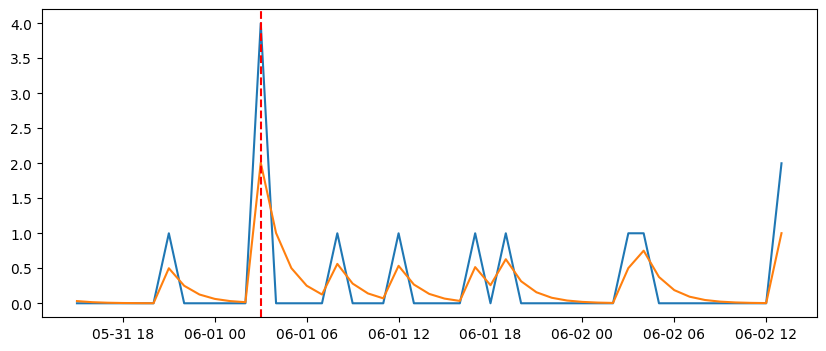

In [7]:
import matplotlib.pyplot as plt

example_id = combined_df.index[11]  # pick first video for demo
g = df[df["videoId"] == example_id][["videoId","ts", "comment_count"]].copy()
g2 = reindex_hourly(g, "comment_count")
g2["ema"] = ema(g2["comment_count"], EMA_SPAN_HOURS)

peak_ts = g2.loc[g2["ema"].idxmax(), "ts"]

# after computing peak_ts
end_ts = min(g2["ts"].max(), peak_ts + pd.Timedelta(hours=MAX_WINDOW_HRS))
g2_plot = g2[(g2["ts"] >= peak_ts - pd.Timedelta(hours=12)) & (g2["ts"] <= end_ts)]
plt.figure(figsize=(10,4))
plt.plot(g2_plot["ts"], g2_plot["comment_count"], label="raw hourly")
plt.plot(g2_plot["ts"], g2_plot["ema"], label=f"EMA (span={EMA_SPAN_HOURS})")
plt.axvline(peak_ts, linestyle="--", color="red", label="peak")
